## 创建一个玩具数据集

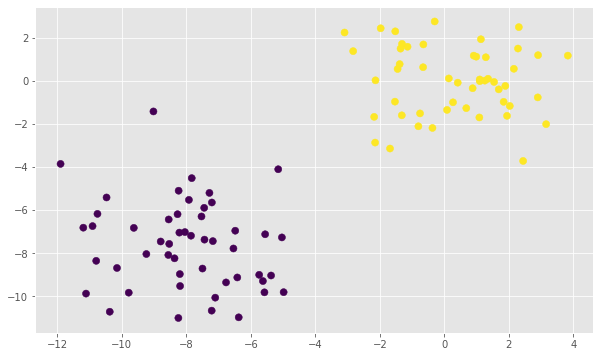

In [1]:
from sklearn import datasets
X, y = datasets.make_blobs(100, 2, centers=2, random_state=1701, cluster_std=2)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

把数据集拆分成训练集和测试集。

In [2]:
import numpy as np
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X.astype(np.float32), y, test_size=0.1
)

## 使用普通贝叶斯分类器对数据进行分类

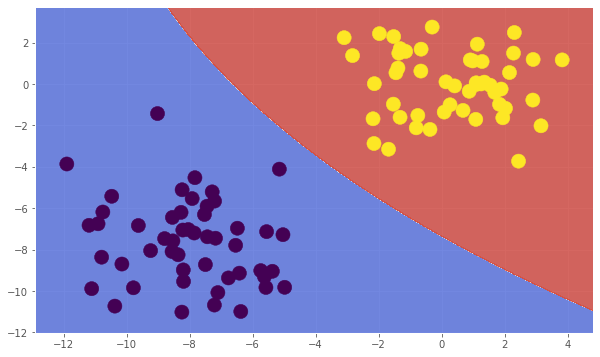

In [3]:
# 1）使用以下函数，我们可以创建一个新分类器：
import cv2
model_norm = cv2.ml.NormalBayesClassifier_create()

# 2）接着，通过train方法进行训练：
model_norm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

# 3）一旦分类器训练成功，就返回True。我们经历了对分类器进行预测和评分的操作，就像我们之前做过百万次一样：
_, y_pred = model_norm.predict(X_test)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

# 4）甚至更好——我们可以重用第6章的绘图函数检验决策边界！如果你还记得的话，我们的思路是创建一个包含所有数据点的网格，再分类网格上的每个点。通过同名的NumPy函数创建网格：
def plot_decision_boundary(model, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # 5）meshgrid函数将返回2个浮点矩阵xx和yy，包含网格上每个坐标点x和y坐标。我们使用ravel函数可以把这些矩阵展开成列向量，并把它们堆叠形成一个新矩阵X_hypo：
    X_hypo = np.column_stack((xx.ravel().astype(np.float32),
                                yy.ravel().astype(np.float32)))
                                
    # 6）现在，X_hypo包含了X_hypo[:, 0]中的所有x值以及X_hypo[:, 1]中的所有y值。这种格式是predict函数可以理解的：
    ret = model.predict(X_hypo)

    # 7）然而，我们希望能够同时使用OpenCV和scikit-learn的模型。这两者之间的区别是OpenCV返回多个变量（表示成功/失败的一个布尔标志以及预测的目标标签），而scikit-learn只返回预测的目标标签。因此，我们可以查看ret输出是否是一个元组，在这种情况下，我们知道我们正在处理OpenCV。在本例中，我们存储元组的第二个元素（ret[1]）。否则，我们正在处理的是scikit-learn，不需要索引到ret：
    if isinstance(ret, tuple):
        zz = ret[1]
    else:
        zz = ret
    zz = zz.reshape(xx.shape)

    # 8）剩下要做的就是创建一个等高线图，其中zz表示网格上每个点的颜色。在此基础上，我们用可靠的散点图绘制数据点：
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

# 9）我们通过传递一个模型（model_norm）、一个特征矩阵（X），以及一个目标标签向量（y）调用函数：
plt.figure(figsize=(10, 6))
plot_decision_boundary(model_norm, X, y)

贝叶斯分类器还返回已被分类的每个数据点的概率：

函数返回一个布尔标志（True表示成功，False表示失败）、预测的目标标签（y_pred）以及条件概率（y_proba）。这里，y_proba是一个N×2的矩阵，表示N个数据点中的每一个数据点分类为0类或者1类的概率：

In [4]:
ret, y_pred, y_proba = model_norm.predictProb(X_test)
y_proba.round(2)

array([[0.  , 0.19],
       [0.19, 0.  ],
       [0.  , 0.07],
       [0.15, 0.  ],
       [0.  , 0.22],
       [0.05, 0.  ],
       [0.02, 0.  ],
       [0.  , 0.16],
       [0.28, 0.  ],
       [0.11, 0.  ]], dtype=float32)

## 使用朴素贝叶斯分类器对数据进行分类

In [5]:
# 1）通过寻求scikit-learn的帮助，我们可以把结果和一个真正的朴素贝叶斯分类器进行比较：
from sklearn import naive_bayes
model_naive = naive_bayes.GaussianNB()

# 2）像往常一样，利用fit方法训练分类器：
model_naive.fit(X_train, y_train)

# 3）对建立的分类器评分：
model_naive.score(X_test, y_test)

# 4）又是一个完美的分数！可是，与OpenCV相反，这个分类器的predict_proba方法返回true的概率值，因为所有的值都在0和1之间，而且所有的行加起来等于1：
yprob = model_naive.predict_proba(X_test)
yprob.round(2)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

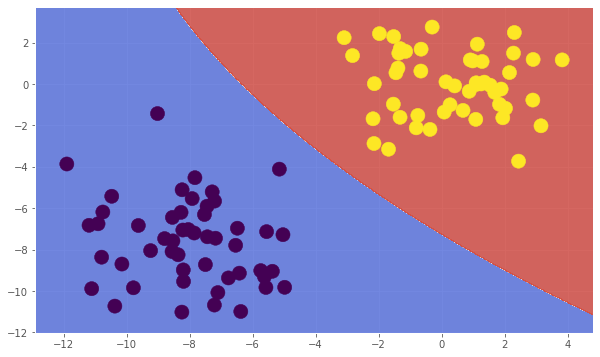

In [6]:
# 5）由朴素贝叶斯分类器返回的决策边界看起来稍有不同，但是为了进行这个练习，可以认为与之前的命令相同：
plt.figure(figsize=(10, 6))
plot_decision_boundary(model_naive, X, y)

## 可视化条件概率

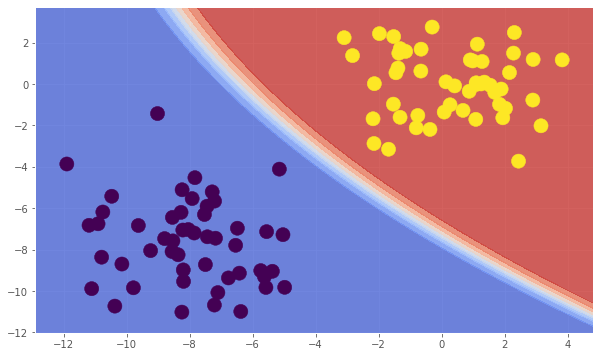

In [7]:
# 1）为了可视化条件概率，我们会对上个例子中的绘图函数稍做修改。首先，我们在（x_min, x_max）和（y_min, y_max）之间创建一个网格：
def plot_proba(model, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # 2）接着，我们展开xx和yy，然后把它们逐列添加到特征矩阵X_hypo中：
    X_hypo = np.column_stack((xx.ravel().astype(np.float32),
                              yy.ravel().astype(np.float32)))

    # 3）如果我们想让这个函数在OpenCV和scikit-learn中都起作用，那么我们需要为predictProb（在OpenCV的情况下）和predict_proba（在scikit-learn的情况下）实现一个开关。为此，我们查看model是否有一个名为predictProb的方法。如果这个方法存在，那么我们就可以调用它；否则，我们假设正在处理的是scikit-learn的一个模型：
    if hasattr(model, 'predictProb'):
        _, _, y_proba = model.predictProb(X_hypo)
    else:
        y_proba = model.predict_proba(X_hypo)

    # 4）y_proba是一个二维矩阵，包含每个数据点、数据属于0类（y_proba[:, 0]）的概率和属于1类（y_proba[:, 1]）的概率。把这两个值转换成contour函数能够理解的颜色的一种简单的方法是取两个概率值的差值：
    zz = y_proba[:, 1] - y_proba[:, 0]
    zz = zz.reshape(xx.shape)

    # 5）最后一步是在彩色网格的顶部把X_test绘制成一个散点图：
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

plt.figure(figsize=(10, 6))
plot_proba(model_naive, X, y)